
# BMIS-2542: Data Programming Essentials with Python 
#### Katz Graduate School of Business, Spring 2021

## Session 11: Social Media Data Mining


Social media data mining has become increasingly popular and important. For example, companies are using social media for customer service, monitoring their Twitter or Facebook feeds in realtime to engage with their customers better. In this notebook, we are going to explore a pre-collected set of tweets to be used for sentiment classification.<br>
We will also discuss about how to connect with APIs to grab data from social media platforms, using Twitter as an example.

On Anaconda prompt (Windows) or Terminal (Mac) run the following command and install the following libraries.
<br><br>
`conda install -c conda-forge wordcloud ` **OR** 
`conda install -c conda-forge/label/gcc7 wordcloud` 

`conda install -c conda-forge tweepy`

`conda install -c conda-forge jsonpickle` **OR**
`conda install -c conda-forge/label/gcc7 jsonpickle `

In [ ]:
# import libraries
import tweepy
from tweepy import API 
from tweepy import OAuthHandler
import traceback
import jsonpickle
import json

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import string
import nltk
from string import punctuation

pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter(action='ignore')

## Accessing APIs for Data: A Twitter Example

Twitter offers a series of APIs to provide programmatic access to Twitter data, including reading tweets, accessing user profiles, and posting content on behalf of a user. <br>

You need to refer to the [Twitter Developer Docs](https://developer.twitter.com/en/docs/basics/getting-started) to learn about working with the **Twitter developer platform**. 

In order to interact with Twitter APIs, we need the following:

- a Twitter account (create one [here](https://twitter.com/)) 
- an approved Twitter Developer account (Apply [here](https://developer.twitter.com/en/apply-for-access))
- a registered Twitter application (create one [here](https://developer.twitter.com/en/apps/create))
- a Twitter API client

Twitter provides more than a single API. We can categorize our options into two classes: **REST APIs** and **Streaming API**.<br>
The Time Dimension of Searching versus Streaming [(Figure 2.1 : Mastering Social Media Mining with Python)](https://proquest-safaribooksonline-com.pitt.idm.oclc.org/9781783552016):
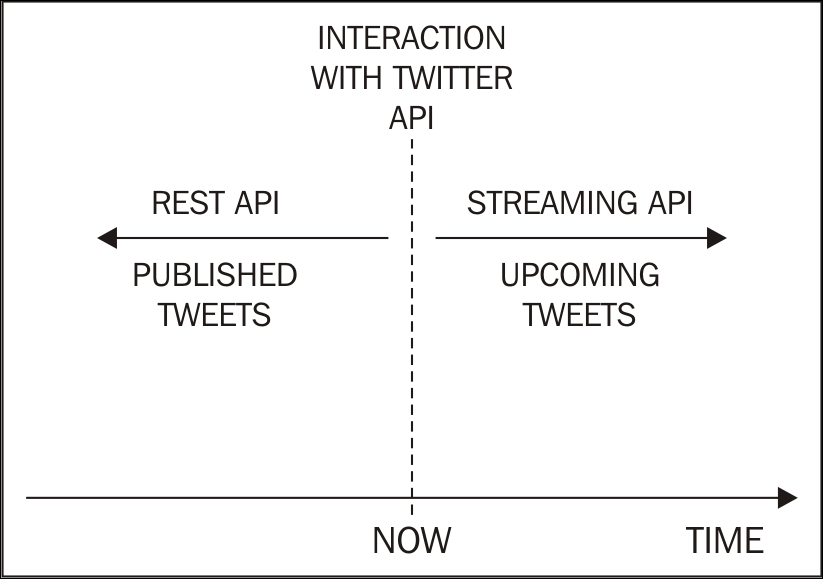

The Twitter API limits access to applications primarily on a per-user basis, or to be more precise, on a per-access-token basis. When the rate limit is exceeded, Twitter will return an error message rather than the data we're asking for. 

Read more about rate limiting in the [Twitter official documentation](https://developer.twitter.com/en/docs/basics/rate-limiting).

**Note: I have created a sample Twitter app for the demonstration today. You need to create your applications using your own Twitter Developer account, to experiment with Twitter APIs.**

The following example is inspired by the global outbreak of the Corona virus.

In [ ]:
# Twitter application credentials
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [ ]:
def get_twitter_auth():
    try: 
        auth = OAuthHandler(consumer_key, consumer_secret) 
        auth.set_access_token(access_token, access_secret) 
        return auth 
    except:
        print(traceback.format_exc())  
        return None

In [ ]:
auth = get_twitter_auth() 
api = API(auth) 

if not api:
    print("Problem connecting to API!")
else:
    print(api)

In [ ]:
searchQuery = '"corona" OR "covid19" OR "covid-19" -filter:retweets lang:en' # hashtag covid-19 or term covid-19 no retweets-only English tweets

Read [here](https://developer.twitter.com/en/docs/tweets/rules-and-filtering/overview/standard-operators) to learn more about search query building.

In [ ]:
#Maximum number of tweets we want to collect 
maxTweets = 1000
#The twitter Search API allows up to 100 tweets per query
tweetsPerQry = 100

In [ ]:
tweetCount = 0

#Open a text file to save the tweets to
with open('corona.json', 'w') as f:
    #Tell the Cursor method that we want to use the Search API (api.search)
    #Also tell Cursor our query, and the maximum number of tweets to return
    for tweet in tweepy.Cursor(api.search,q=searchQuery).items(maxTweets) :         
            #Write the JSON format to the text file, and add one to the number of tweets we've collected
            f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
            tweetCount += 1

    #Display how many tweets we have collected
    print("Downloaded {0} tweets".format(tweetCount))

In [ ]:
#Let's look at what we are actually printing to text  (if you don't know what JSON is: http://json.org/)
tweet._json

In [ ]:
def pop_tweets(path):
    #Declare a new data frame with pandas, with some specific column names
    tweets = pd.DataFrame(columns=['CreatedDate','TweetID','ScreenName','UserId','Tweet'])

    #Open the text file that contains the tweets we collected
    tweets_file = open(path, "r")
    
    #Read the text file line by line
    for line in tweets_file:
        
        #Load the JSON information
        tweet = json.loads(line)
        
        #If the tweet isn't empty, add it to the data frame
        if ('text' in tweet): 
            tweets.loc[len(tweets)]=[tweet['created_at'], tweet['id'], tweet['user']['screen_name'], tweet['user']['id'], tweet['text']]    
    return tweets

In [ ]:
corona_tweets = pop_tweets('corona.json')

In [ ]:
corona_tweets.head()

In [ ]:
def process_tweet(tweet):
    try:         
        #Convert to lower case
        tweet = tweet.lower()       
        
        #Convert https?://* to URL
        tweet = re.sub('((www\.[\s]+)|(https?://[^\s]+))','URL',tweet)
        
        #Convert @username to AT_USER
        tweet = re.sub('@[^\s]+','ATUSER',tweet) 
        
        #Replace everything that are not alphabetical characters with a space
        tweet =  re.sub('[^a-zA-Z]', " ", tweet)
        
        #Remove additional white spaces
        tweet = re.sub('[\s]+', ' ', tweet)
        
        #Replace #word with word (hashtags)
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
      
        #trim
        tweet = tweet.strip()
        
        #remove first/last " or 'at string end
        tweet = tweet.rstrip('\'"')
        tweet = tweet.lstrip('\'"')        
        
        stopword_list = nltk.corpus.stopwords.words('english')        
        stopword_list.append('ATUSER')
        stopword_list.append('URL')           
        
        tokenized_tweet = [token.strip(punctuation) for token in tweet.split() if token not in stopword_list]
      
        tweet = ' '.join(tokenized_tweet)      
            
        return tweet
    except: 
        err=traceback.format_exc()
        return ''

In [ ]:
corona_tweets['tidy_tweet'] = corona_tweets['Tweet'].apply(process_tweet)
corona_tweets.head(10)

In [ ]:
all_words = ' '.join([text for text in corona_tweets['tidy_tweet']])
stopwords = set(STOPWORDS)
stopwords.update(['corona', 'covid','virus','coronavirus'])

In [ ]:
wordcloud = WordCloud(width=800, height=500, stopwords = stopwords, collocations=False, random_state=21, max_words=100, background_color="white").generate(all_words)

plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("corona.png");

To create your word cloud in a particular shape, we can use an image of the shape along with the `mask` parameter.

In [ ]:
tear_mask = np.array(Image.open("tear.jpg")) # image downloaded from http://getdrawings.com/teardrop-silhouette

wordcloud = WordCloud(width=800, height=500, stopwords = stopwords, mask = tear_mask, random_state=21, max_words=100, background_color="white").generate(all_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("corona_tear.png");

In [ ]:
corona_tweets.to_csv('corona.csv', index = False)

Read on how to connect to Twitter's streaming API using Tweepy [here](http://docs.tweepy.org/en/v3.4.0/streaming_how_to.html).

### References 
 - Book: [Mastering Social Media Mining with Python)](https://proquest-safaribooksonline-com.pitt.idm.oclc.org/9781783552016)